<a href="https://colab.research.google.com/github/dineshRaja29/Learning-From-Others/blob/main/0_18_Losses_Part_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Recitation 0: Losses

TA: Shrey Jain (shreyj@andrew.cmu.edu)

# Part 2

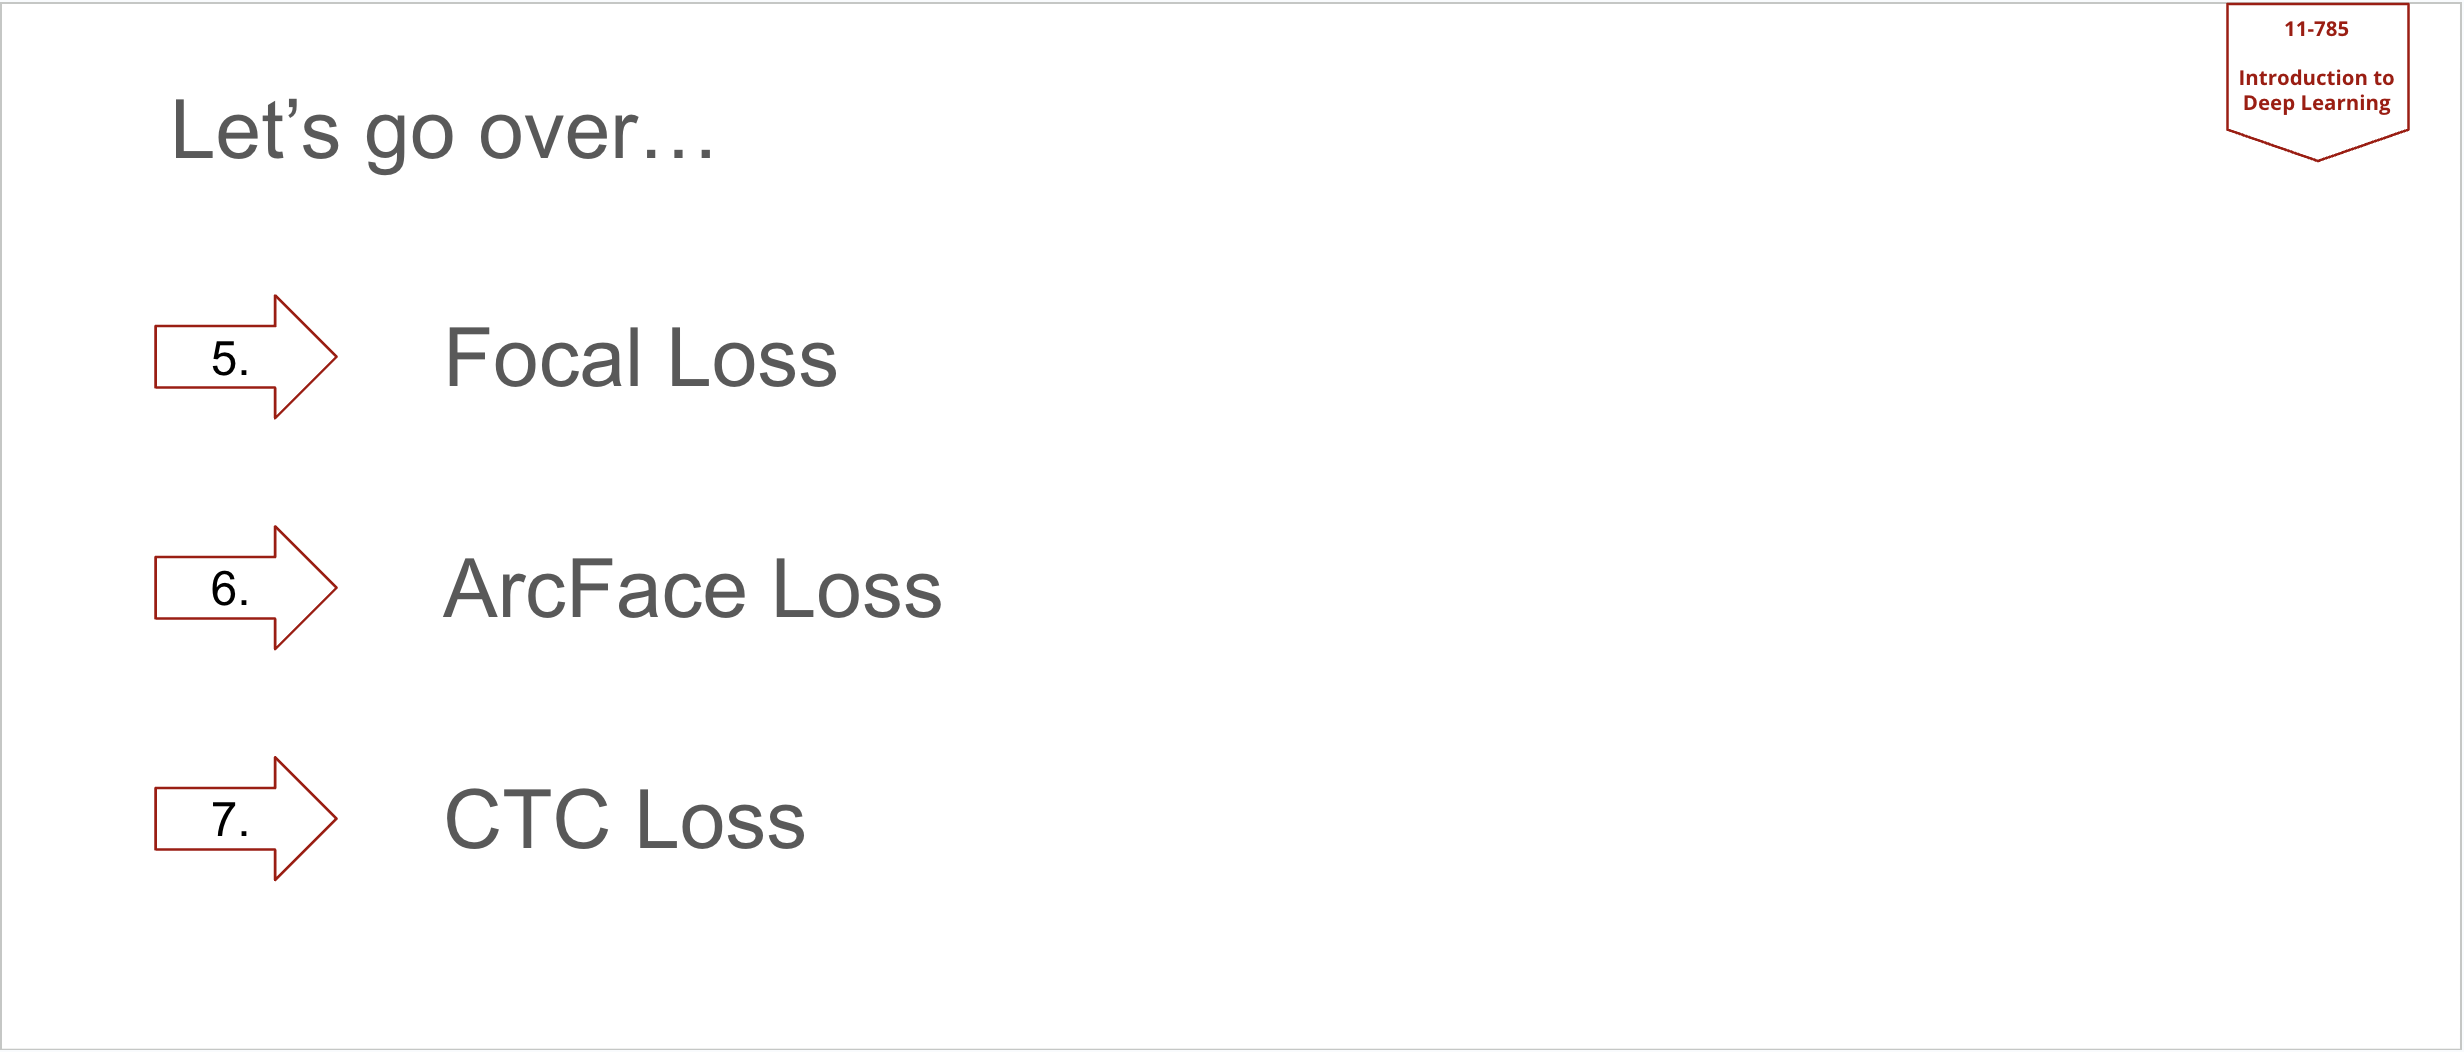

## 5. Focal Loss

### Example 1: Focal Loss

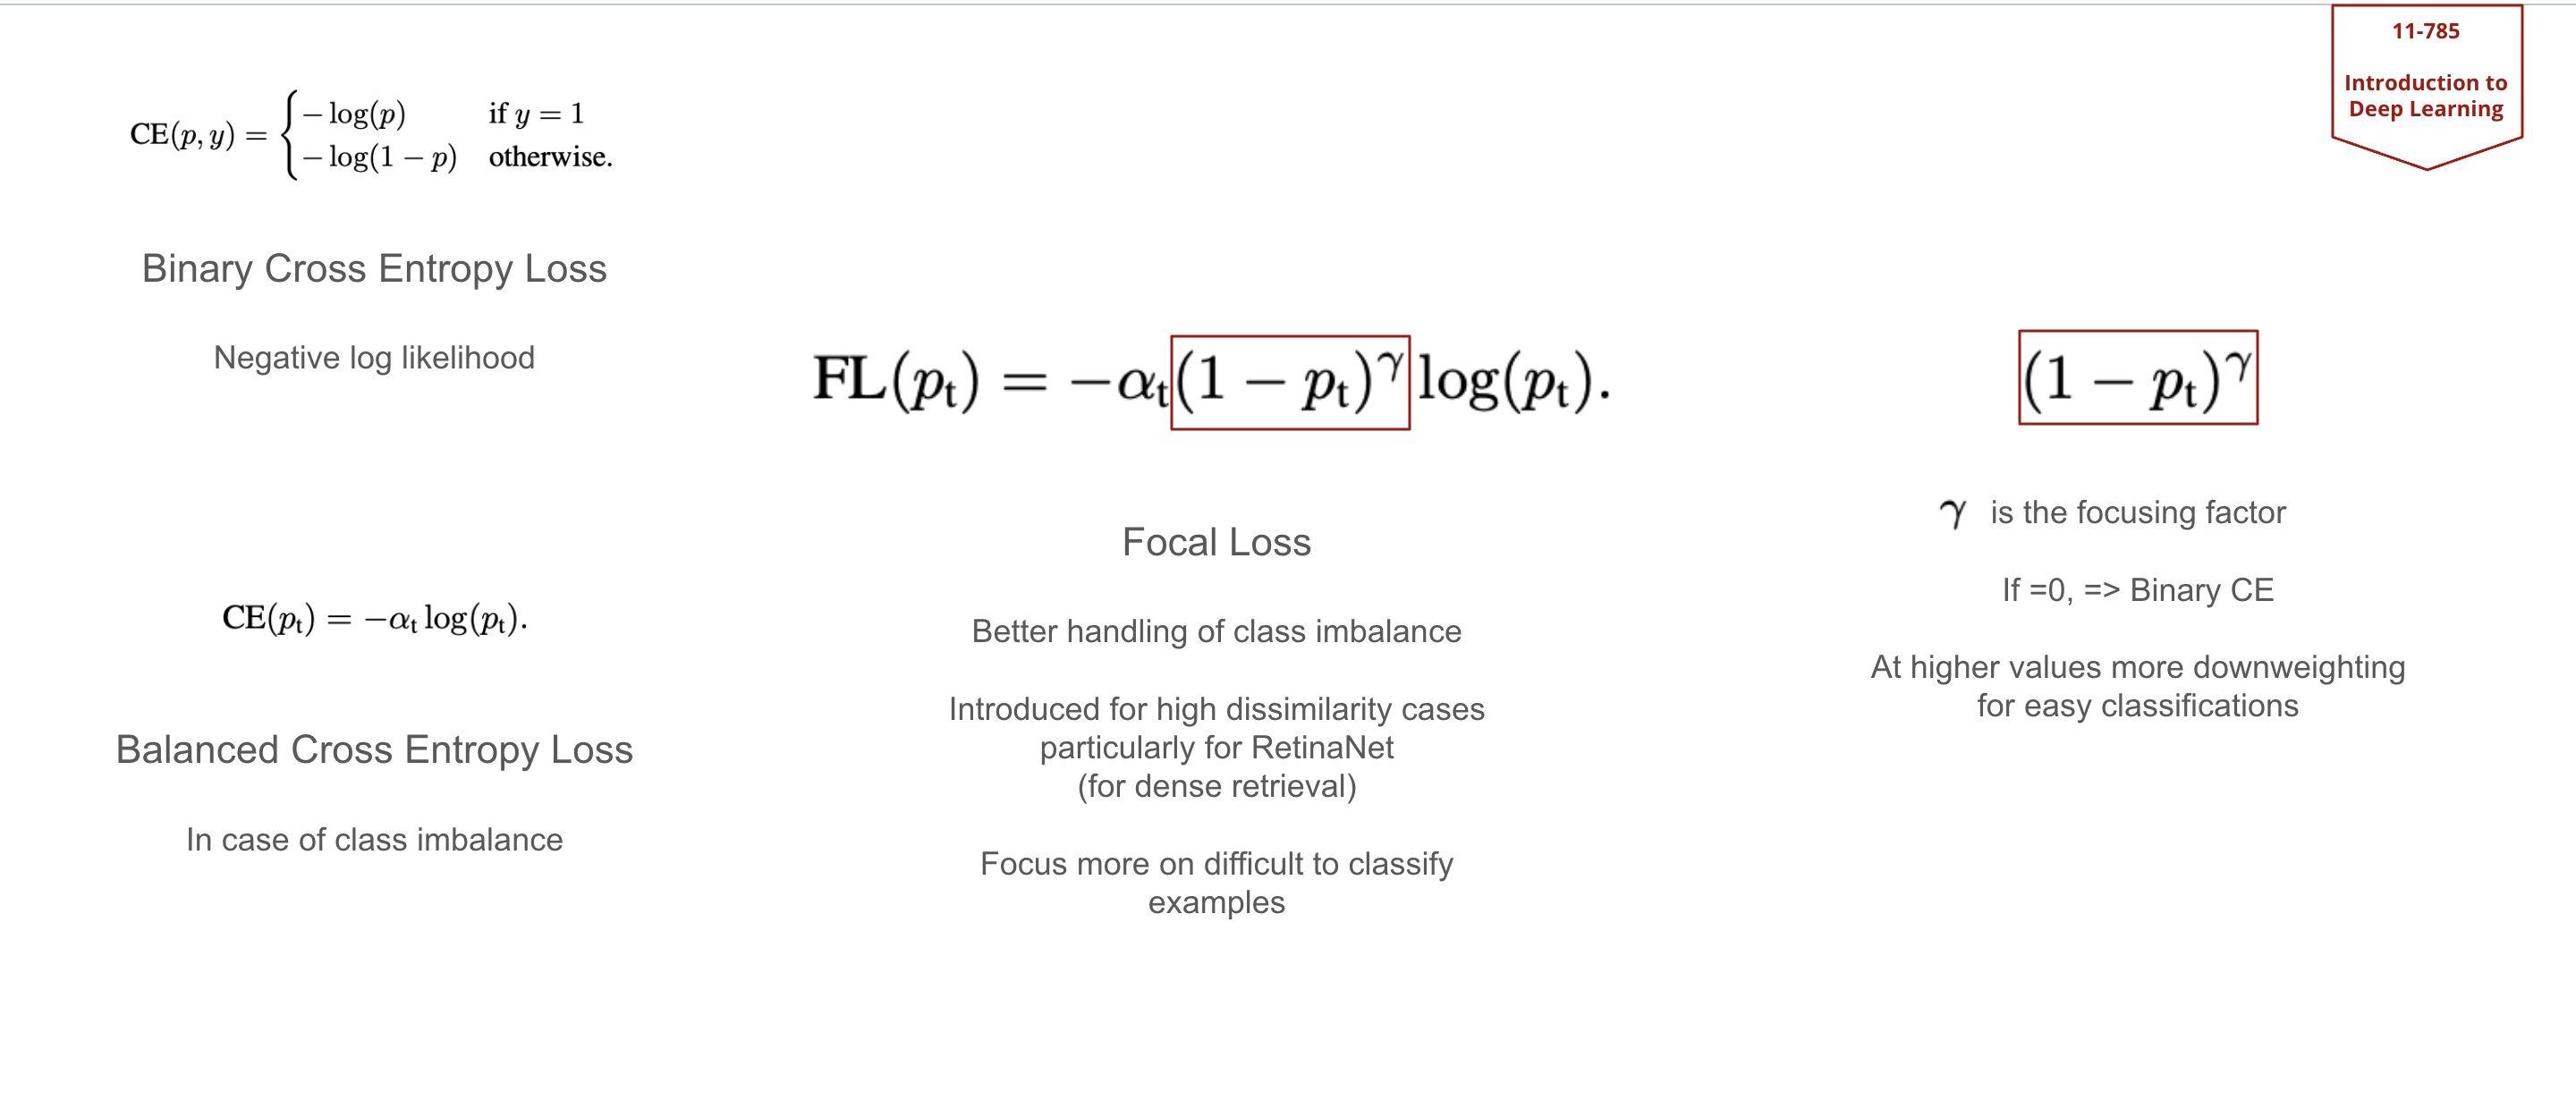

- Beyond object detection, focal loss can benefit any task with pronounced class imbalance, such as medical imaging or fraud detection.

The formula for Focal Loss is defined as follows:

$$
\text{Focal Loss}(p_t) = -\alpha_t (1 - p_t)^\gamma \log(p_t)
$$

where:
- $ p_t $ is the probability associated with the true class.
- $ \alpha_t $ is a weighting factor for class $t$.
- $ \gamma $ is the focusing parameter.

Note that when $\gamma$ is 0, the formula is the same as binary cross entropy loss


### Visualizing focal loss against Cross Entropy Loss



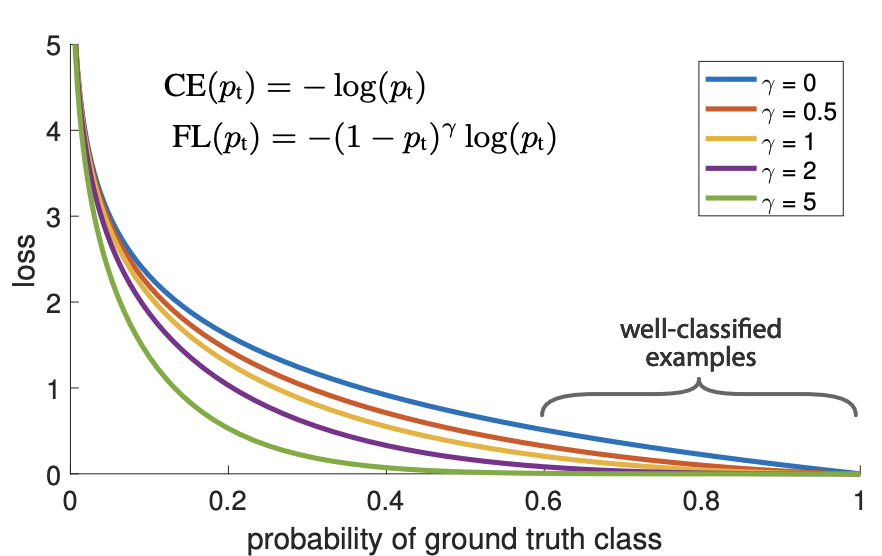

### Focal Loss Implementation in PyTorch

It is a stateless loss i.e. it maintains no state - no weights or biases are stored. Hence, it can be implemented at a function

In [ ]:
# source https://pytorch.org/vision/stable/_modules/torchvision/ops/focal_loss.html

import torch
import torch.nn.functional as F

from ..utils import _log_api_usage_once


def sigmoid_focal_loss(
    inputs: torch.Tensor,
    targets: torch.Tensor,
    alpha: float = 0.25,
    gamma: float = 2,
    reduction: str = "none",
) -> torch.Tensor:
    """
    Loss used in RetinaNet for dense detection: https://arxiv.org/abs/1708.02002.

    Args:
        inputs (Tensor): A float tensor of arbitrary shape.
                The predictions for each example.
        targets (Tensor): A float tensor with the same shape as inputs. Stores the binary
                classification label for each element in inputs
                (0 for the negative class and 1 for the positive class).
        alpha (float): Weighting factor in range (0,1) to balance
                positive vs negative examples or -1 for ignore. Default: ``0.25``.
        gamma (float): Exponent of the modulating factor (1 - p_t) to
                balance easy vs hard examples. Default: ``2``.
        reduction (string): ``'none'`` | ``'mean'`` | ``'sum'``
                ``'none'``: No reduction will be applied to the output.
                ``'mean'``: The output will be averaged.
                ``'sum'``: The output will be summed. Default: ``'none'``.
    Returns:
        Loss tensor with the reduction option applied.
    """
    # Original implementation from https://github.com/facebookresearch/fvcore/blob/master/fvcore/nn/focal_loss.py

    if not torch.jit.is_scripting() and not torch.jit.is_tracing():
        _log_api_usage_once(sigmoid_focal_loss)
    p = torch.sigmoid(inputs)
    ce_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction="none")
    p_t = p * targets + (1 - p) * (1 - targets)
    loss = ce_loss * ((1 - p_t) ** gamma)

    if alpha >= 0:
        alpha_t = alpha * targets + (1 - alpha) * (1 - targets)
        loss = alpha_t * loss

    # Check reduction option and return loss accordingly
    if reduction == "none":
        pass
    elif reduction == "mean":
        loss = loss.mean()
    elif reduction == "sum":
        loss = loss.sum()
    else:
        raise ValueError(
            f"Invalid Value for arg 'reduction': '{reduction} \n Supported reduction modes: 'none', 'mean', 'sum'"
        )
    return loss

## 6. Arc Face Loss

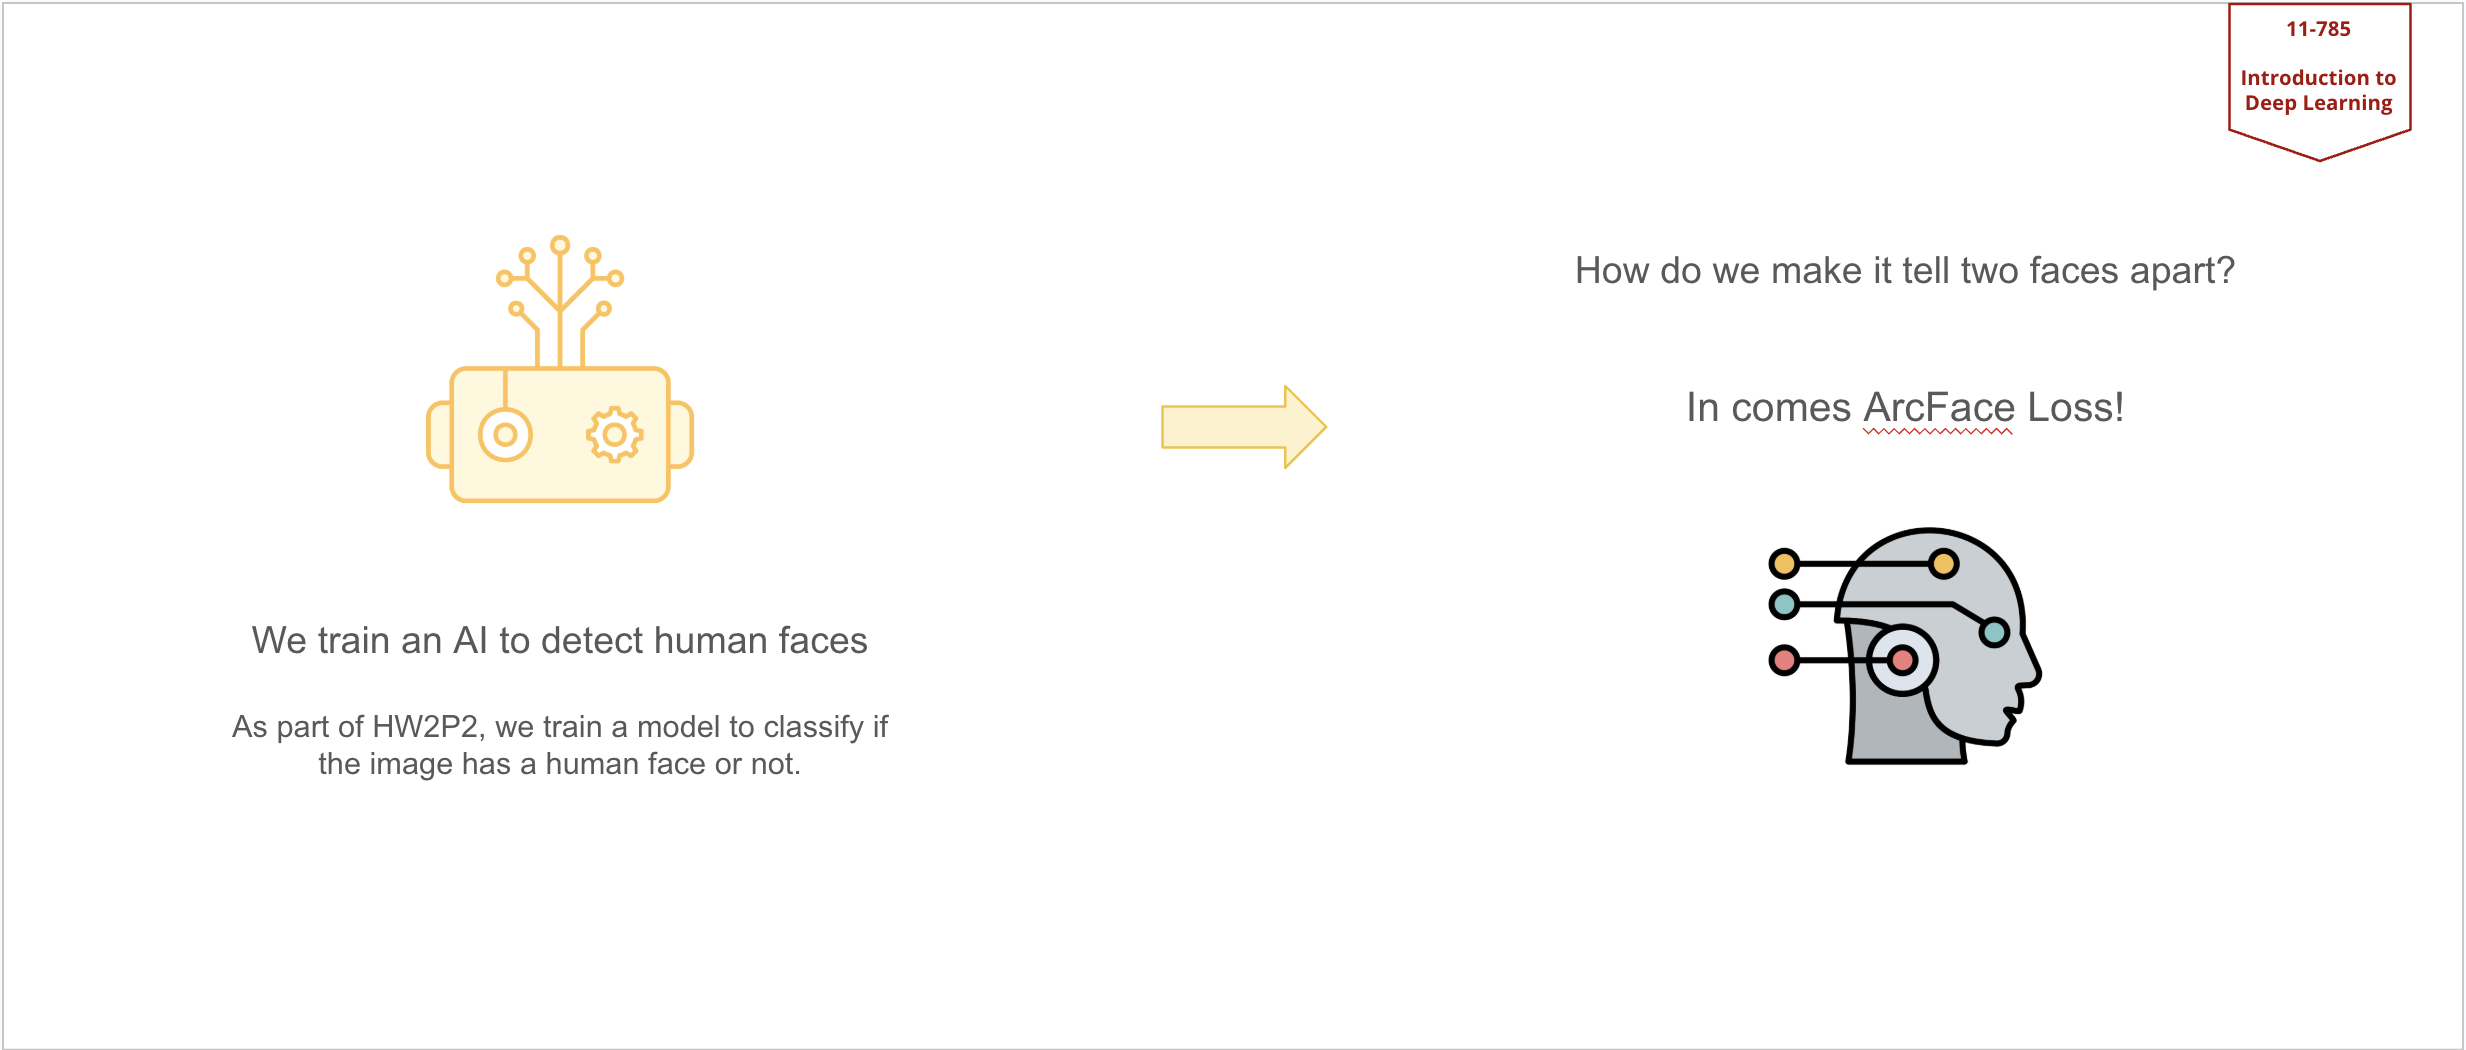




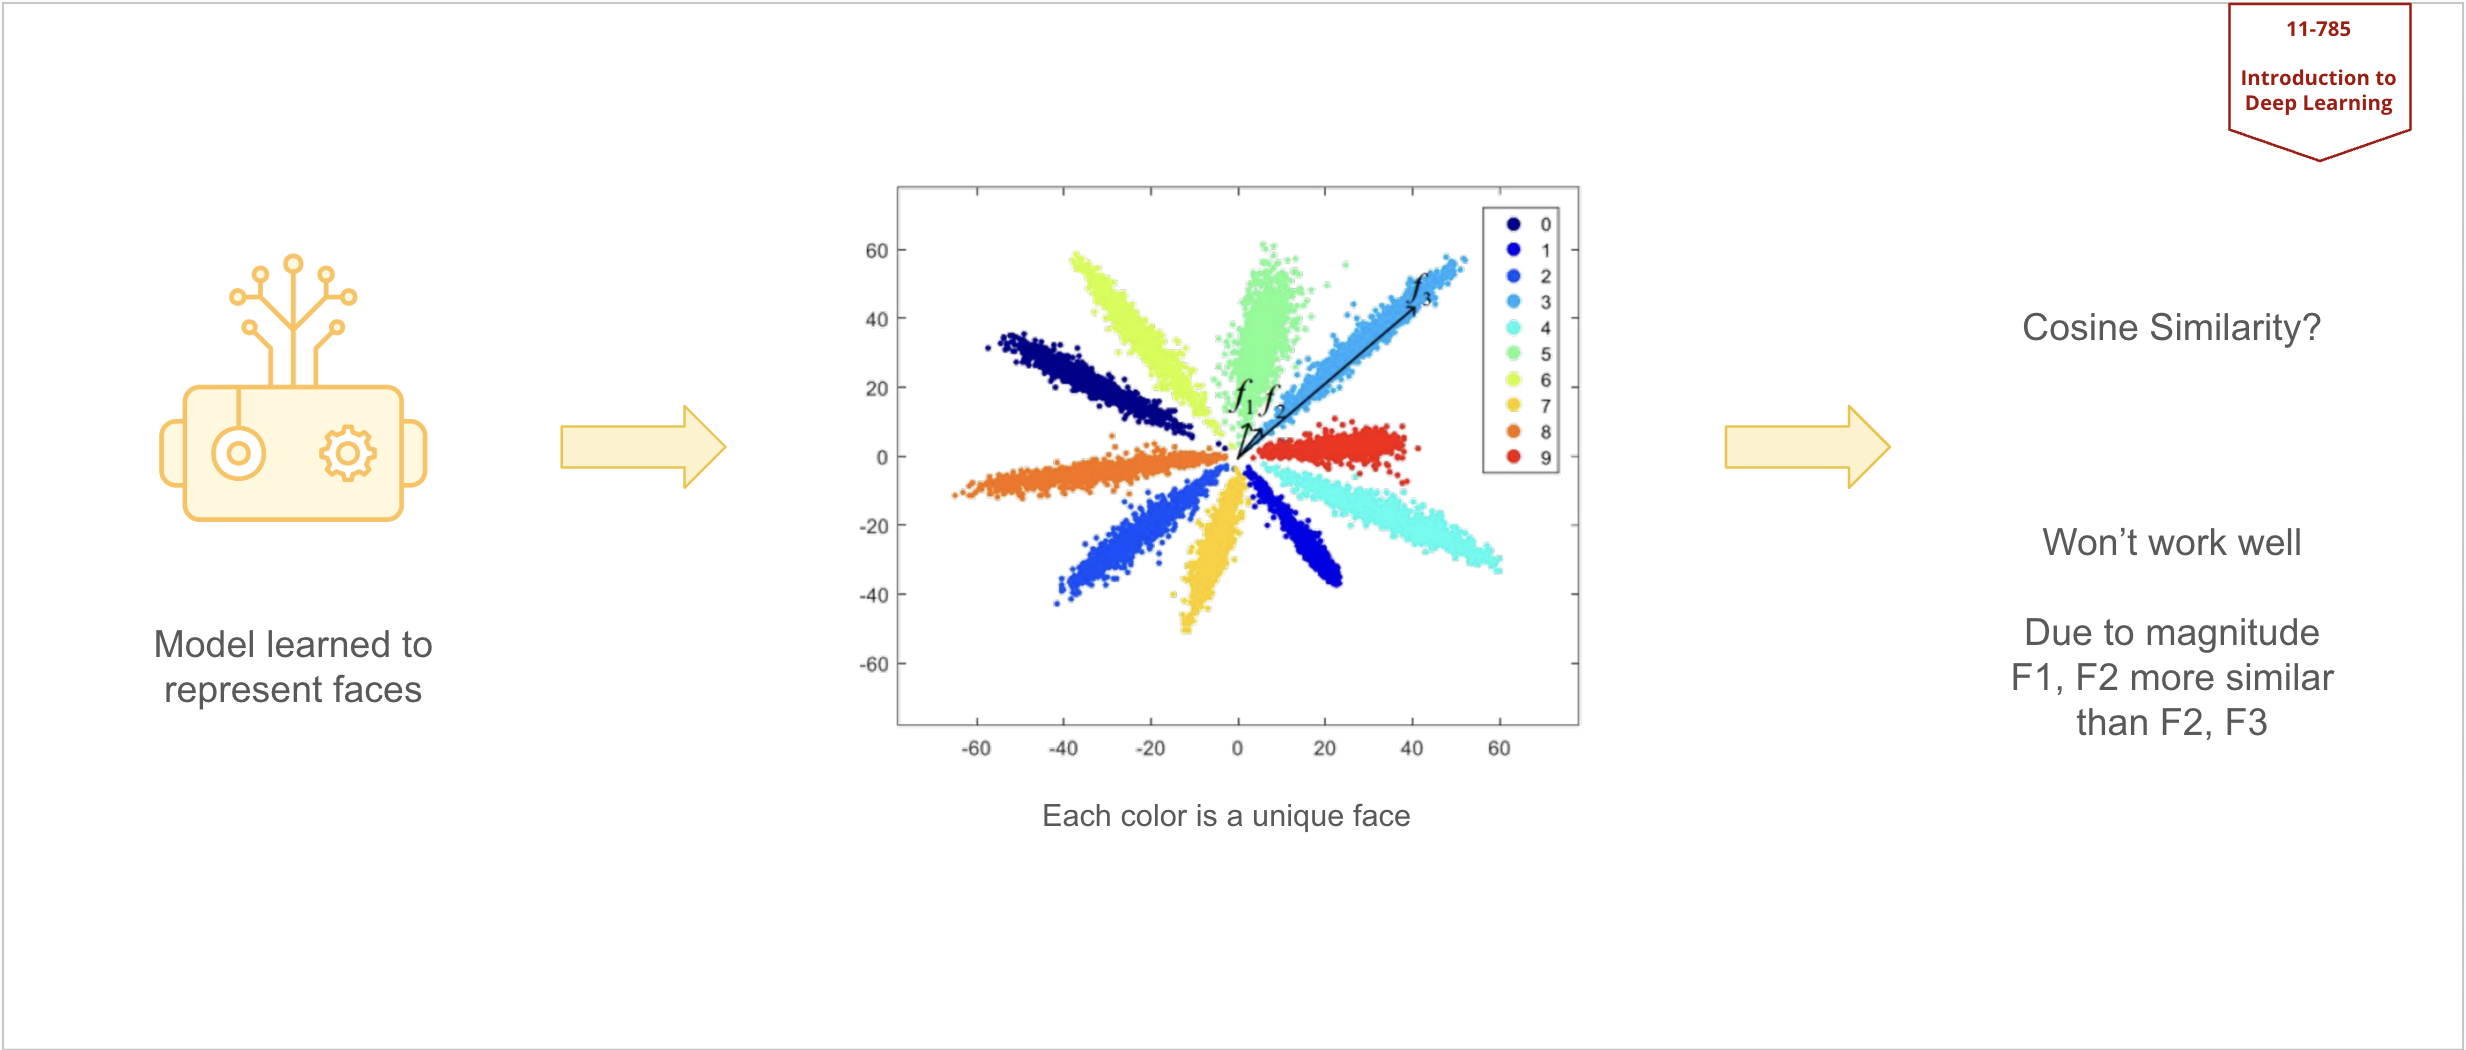

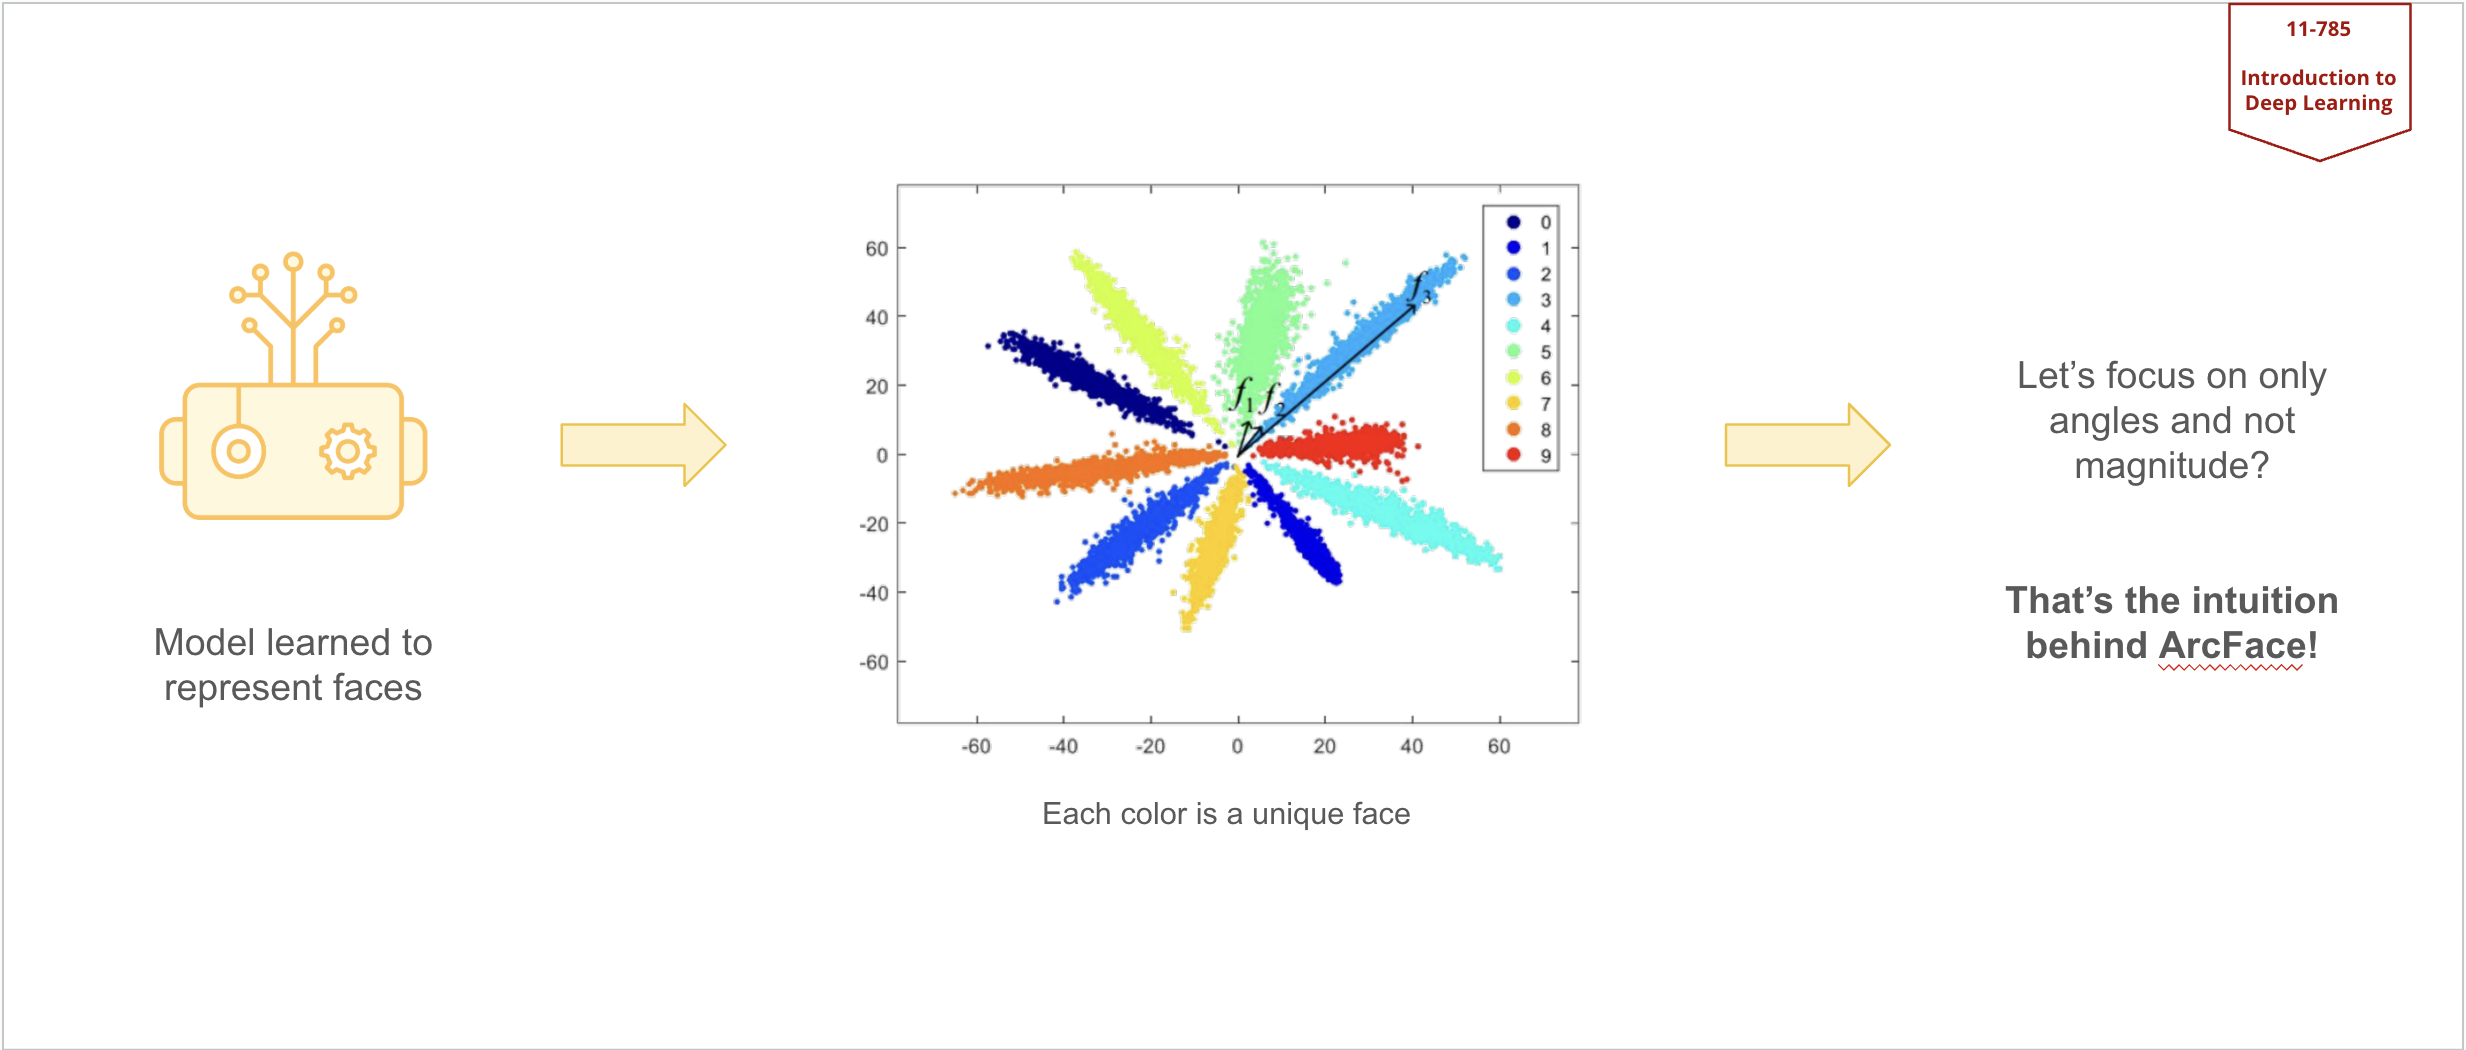

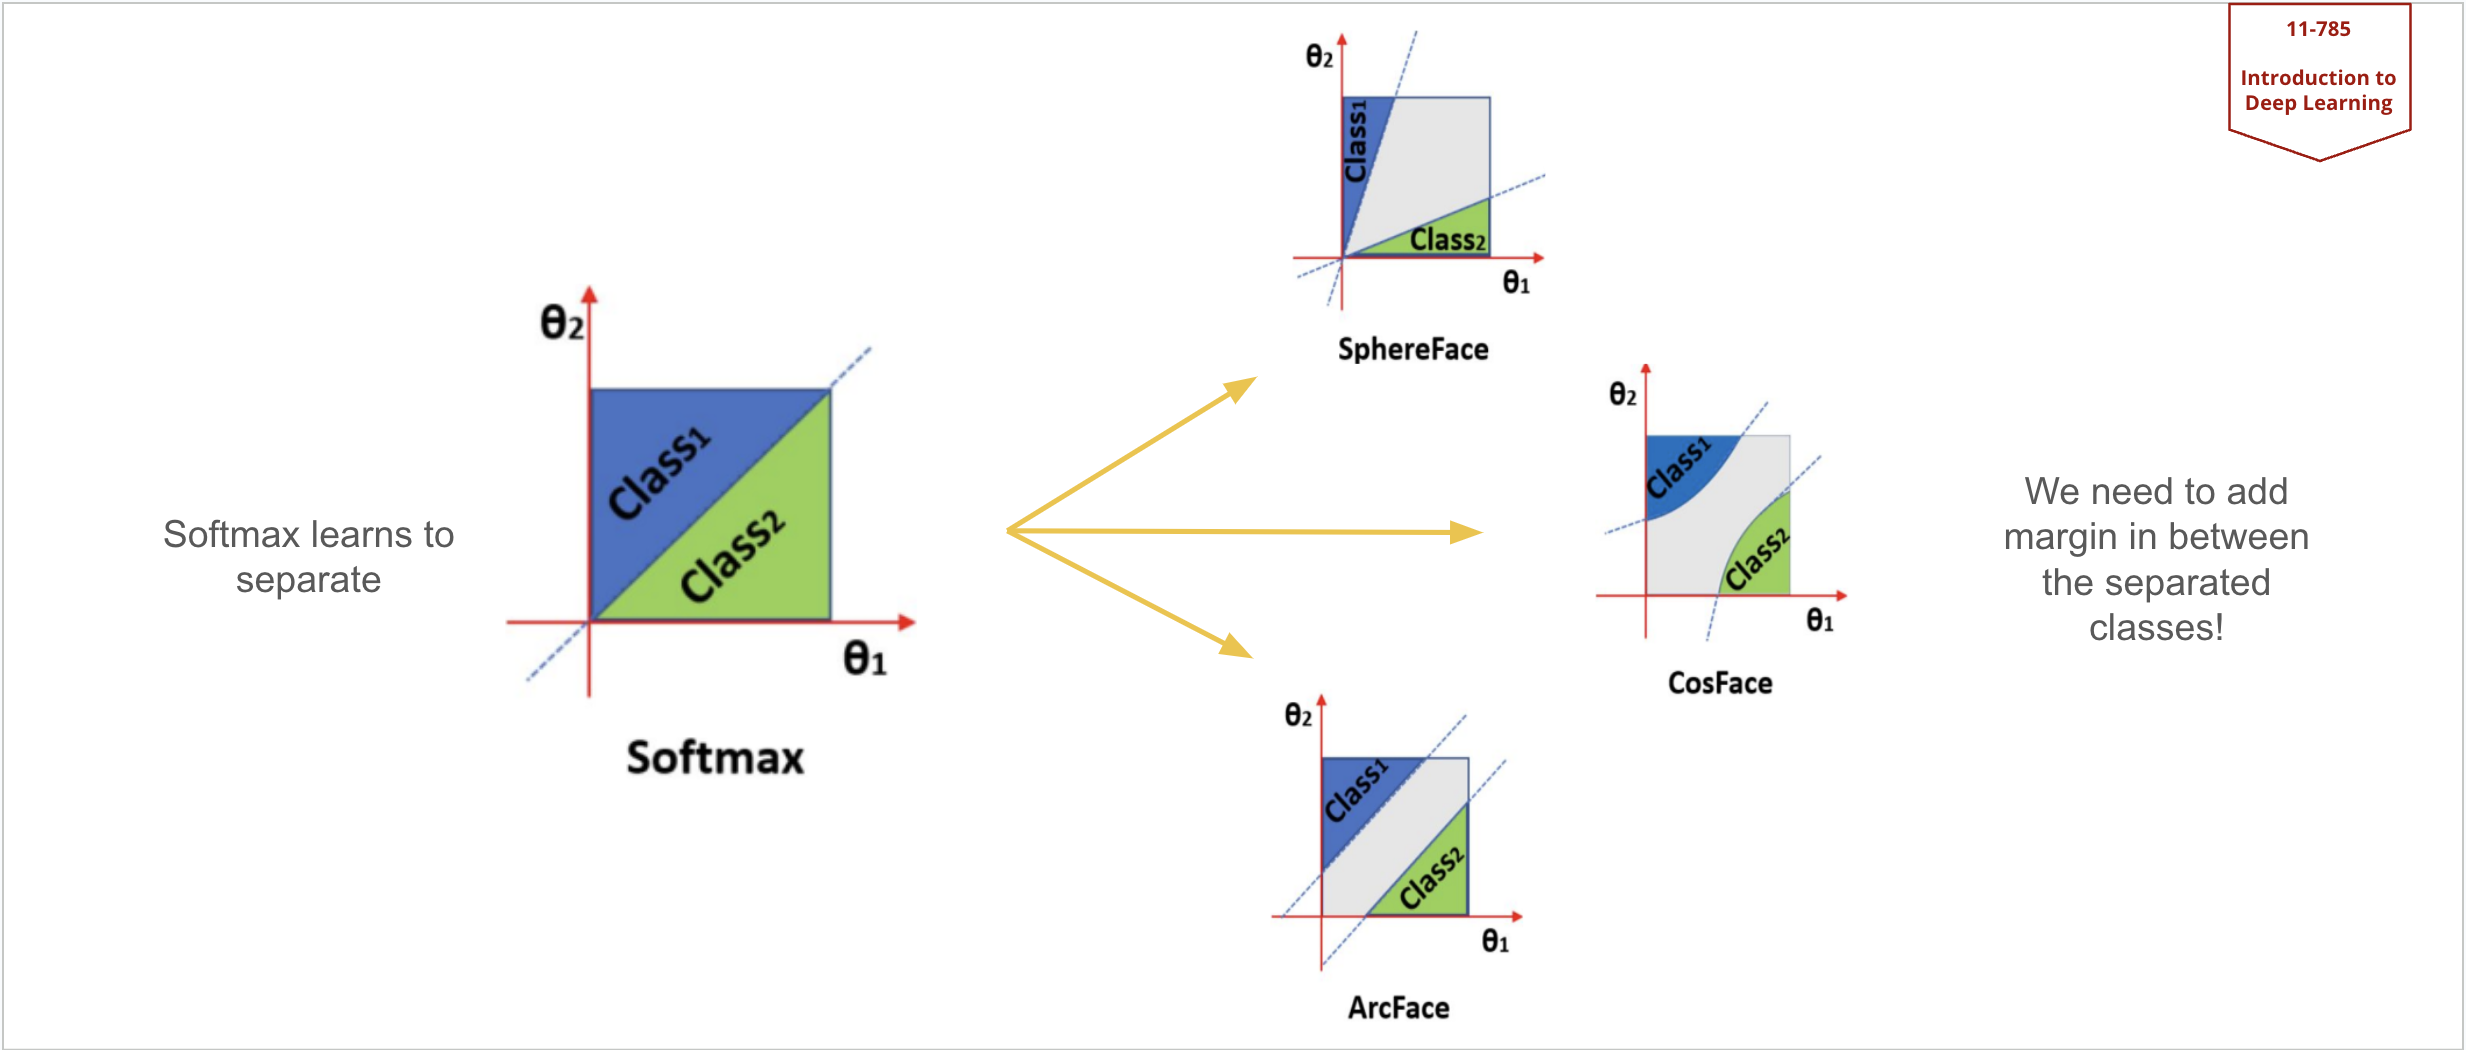

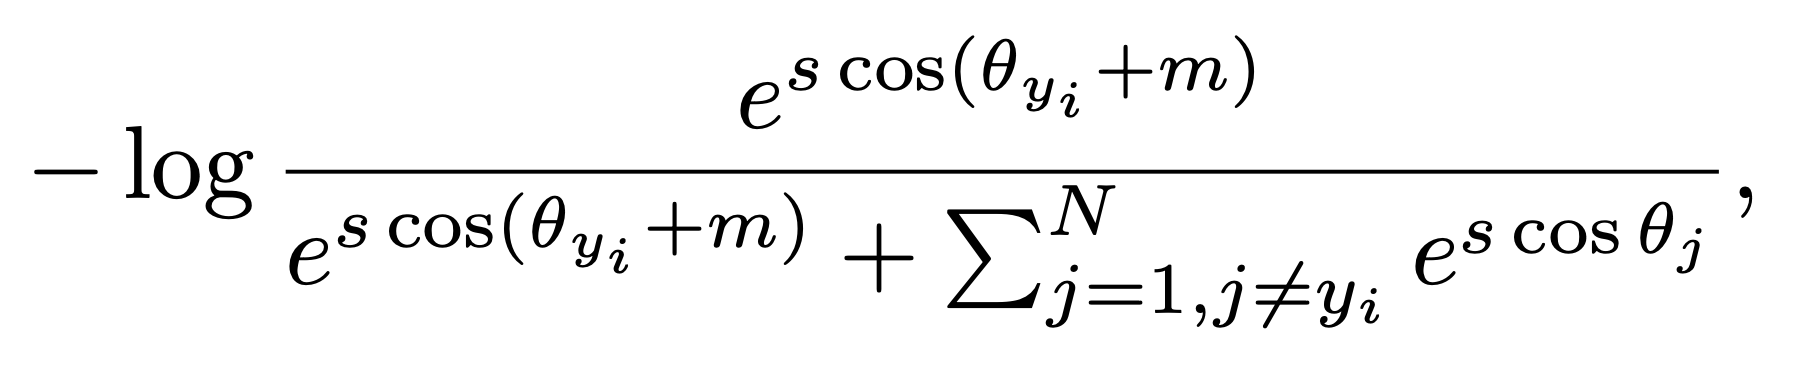

In [ ]:
# Pseudocode

class ArcFaceHead(nn.Module):
    # this is implemented as a stateful class that inherits from nn.Module

    # weights matrix to do a linear transformation
    lin_trans = nn.Linear(img_representation_length, num_faces)

    # hyperparameters for ArcFace (margin, scale)
    m, s

    def forward(img_representation):
        lin_trans(img_representation)

        # arccos aka cos inverse logic to derive theta js
        theta = ...

        # some more tedious math
        cos_theta = ...

        # roughly something like this happens
        return (F.softmax(cos_theta))

face_classification_model = SomeCNN(...)
arcFaceInstance = ArcFaceHead(...)

# usually optimizer = torch.optim.AdamW(face_classification_model.parameters(), lr=config['lr'])
# IMPORTANT: now since Arc Face is a stateful layer, we keep its params in optimizer too
optimizer = torch.optim.AdamW([ {'params': face_classification_model.parameters()},
                                {'params': arcface.parameters()}],
                              lr=config['lr'])

def train(face_classification_model, arcFaceInstance):

    for img, target in dataset:
        img_representation = face_classification_model.forward(input_image)

        #loss = CELoss(img_representation)
        loss = CELoss(arcFaceInstance(img_representation), target)

        optimizer.step(...)

## 7. CTC Loss

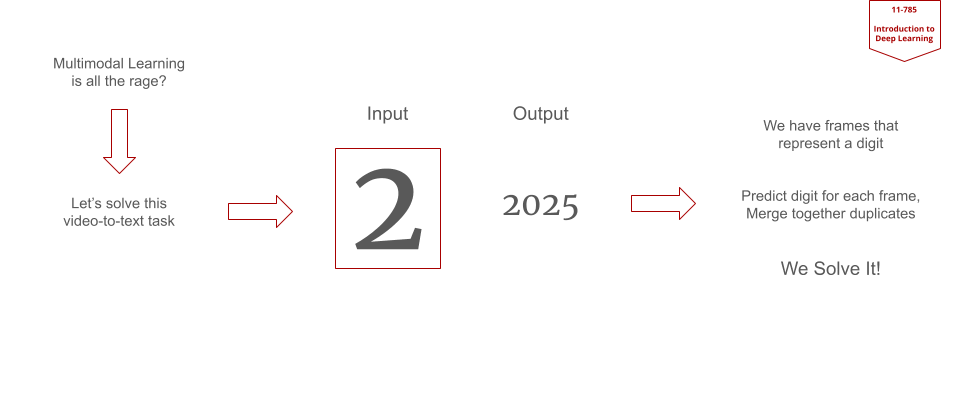

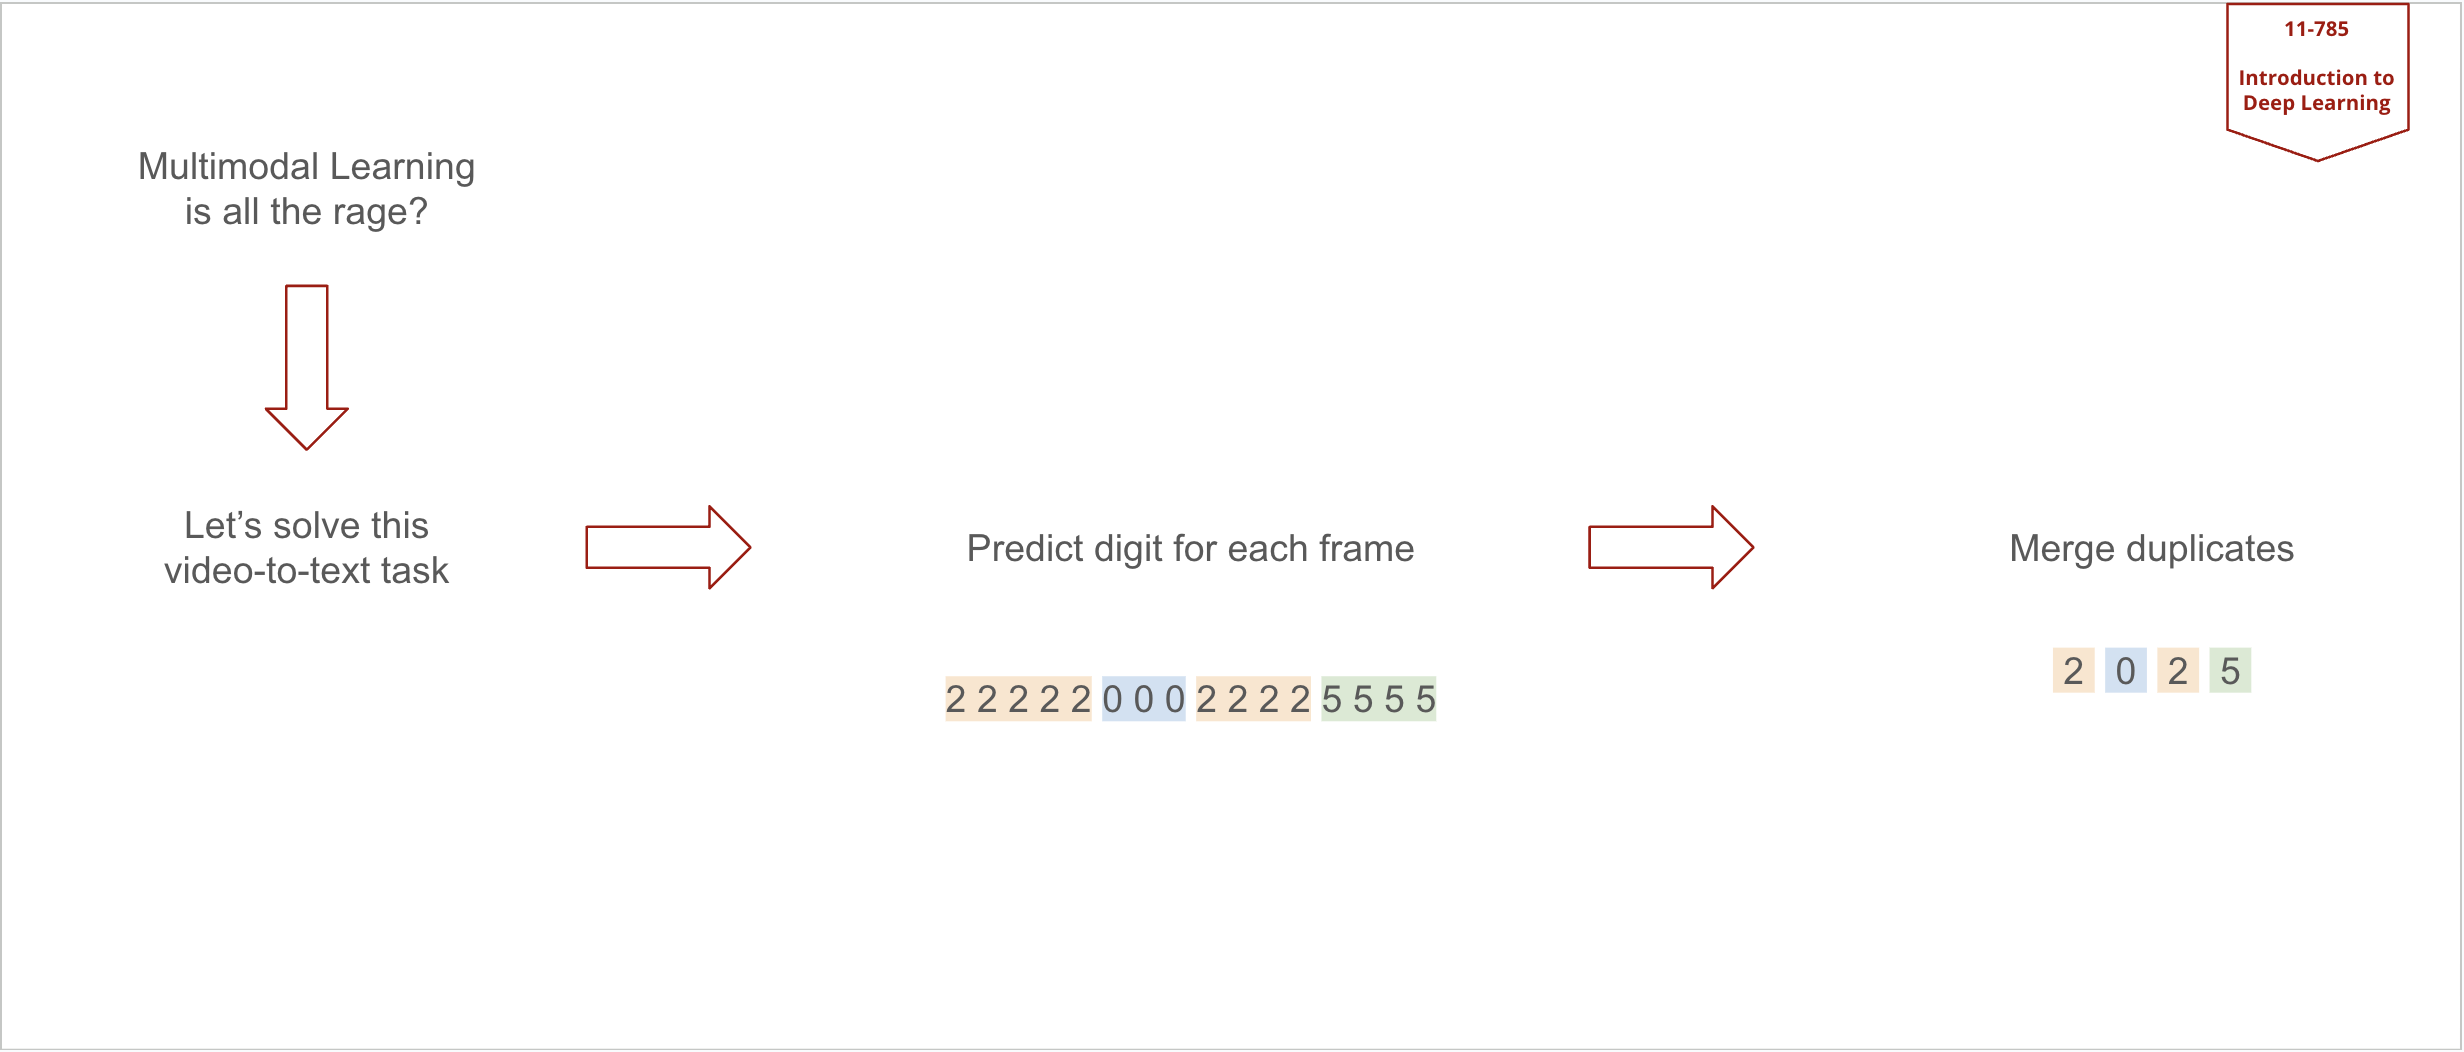

We didn't have frame by frame target and for such cases where alignment doesn't exist, we use Connectionist Temporal Classification (CTC) Loss.

Used for sequence-to-sequence tasks where the input and output lengths are different, and the alignment between them is not known.

Fret not, you'll learn all about this in class ;)


Here's a quick implementation:

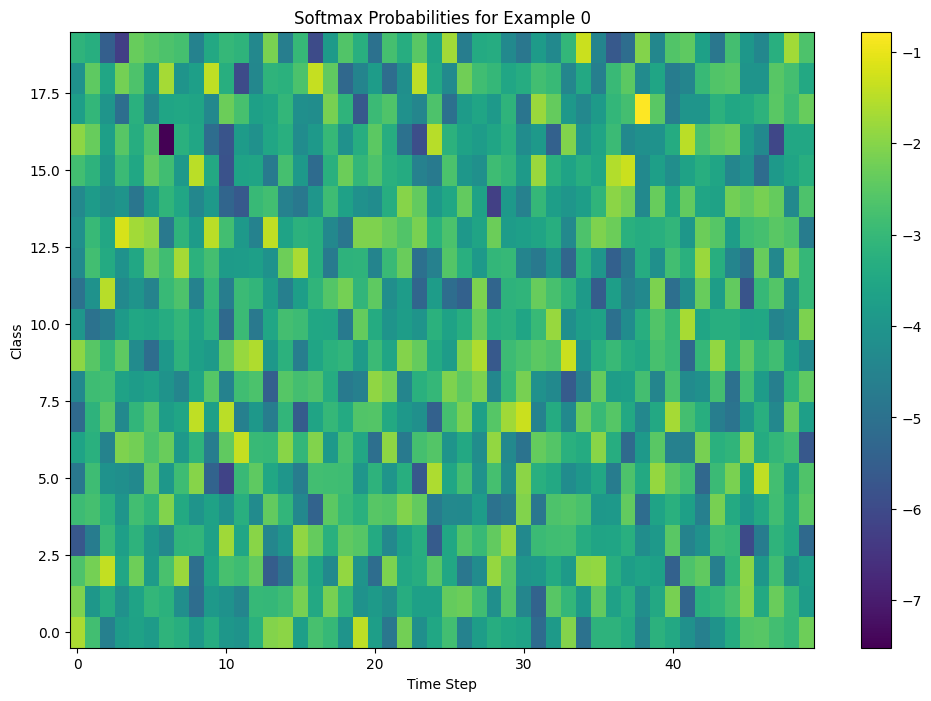

Target sequence for example 0:
[18  5 14 19 12  6  3 18  8 12  6  1 18 15 13 17  2  1 18  2  4 15 14  2
 17  1 16 12 11 15]


In [ ]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

# Set random seed for reproducibility
torch.manual_seed(42)

# Target are to be padded
T = 50      # Input sequence length
C = 20      # Number of classes (including blank)
N = 16      # Batch size
S = 30      # Target sequence length of longest target in batch (padding length)
S_min = 10  # Minimum target length, for demonstration purposes

# Initialize random batch of input vectors, for size = (T, N, C)
input = torch.randn(T, N, C).log_softmax(2).detach().requires_grad_()

# Initialize random batch of targets (0 = blank, 1:C = classes)
target = torch.randint(low=1, high=C, size=(N, S), dtype=torch.long)

# Note that the input sequence length is different from target sequence length
input_lengths = torch.full(size=(N,), fill_value=T, dtype=torch.long)
target_lengths = torch.randint(low=S_min, high=S, size=(N,), dtype=torch.long)

# Initialize CTC loss function
ctc_loss = nn.CTCLoss()

# Compute the loss
loss = ctc_loss(input, target, input_lengths, target_lengths)
loss.backward()

# Documentation: https://pytorch.org/docs/stable/generated/torch.nn.CTCLoss.html

example_idx = 0

example_input = input[:, example_idx, :].detach().numpy()
example_target = target[example_idx, :].detach().numpy()

# plt.figure(figsize=(12, 8))
# plt.imshow(example_input.T, aspect='auto', origin='lower', interpolation='none')
# plt.colorbar()
# plt.xlabel('Time Step')
# plt.ylabel('Class')
# plt.title(f'Softmax Probabilities for Example {example_idx}')
# plt.show()

print(f'Target sequence for example {example_idx}:')
print(example_target)

In [ ]:
input_lengths, target_lengths

(tensor([50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50]),
 tensor([10, 11, 23, 25, 13, 19, 14, 15, 11, 16, 26, 20, 18, 10, 18, 12]))

# Summary

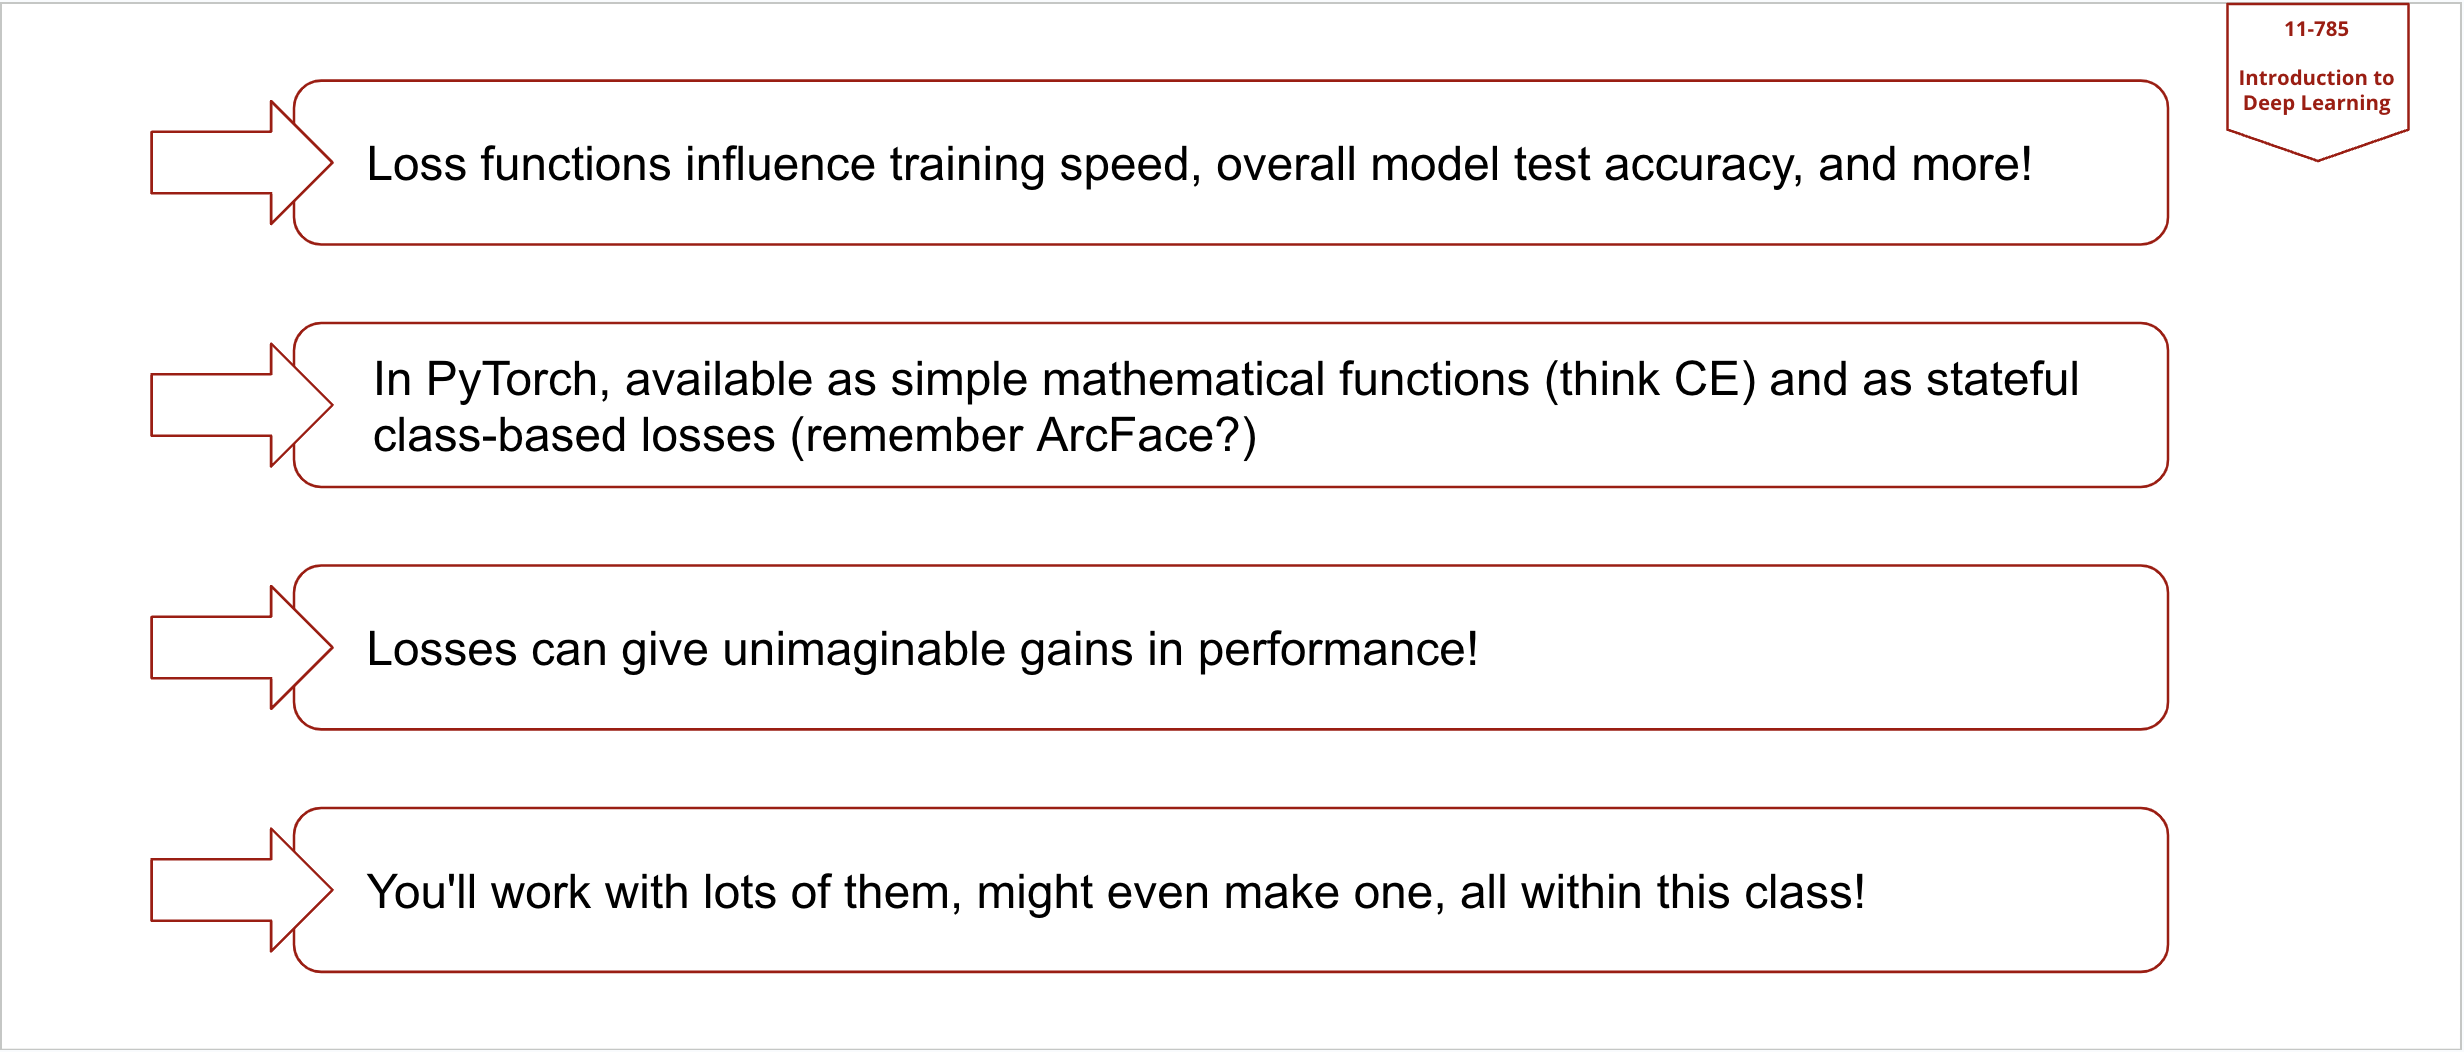

# References and further reading

1. A comprehensive survey on losses in machine learning: https://faculty.ist.psu.edu/vhonavar/Courses/ds310/lossfunc.pdf

2. Pytorch implementation of losses - https://pytorch.org/docs/stable/nn.html

3. Focal Loss for Dense Object Detection - https://arxiv.org/abs/1708.02002

4. Arc Face Loss - https://arxiv.org/abs/1801.07698

